In [8]:
import os
import json
from phoenix.otel import register
from opentelemetry.trace import Status, StatusCode


phoenix_headers = {
    "api-key": os.environ.get("ARIZE_PHNX"),
    "Authorization": f"Bearer {os.environ.get('ARIZE_PHNX')}",
}

# Initialize Phoenix with proper authentication and content type
tracer_provider = register(
    project_name="lexilaw_agent",
    endpoint="https://app.phoenix.arize.com/s/rajatsharma786-rs/v1/traces",
    headers=phoenix_headers,
    # batch=True,
    auto_instrument=True,
)

c:\Users\DELL\anaconda3\envs\lexilawagent\Lib\site-packages\phoenix\otel\otel.py:434: UserWarning: Could not infer collector endpoint protocol, defaulting to HTTP.
  warnings.warn("Could not infer collector endpoint protocol, defaulting to HTTP.")


OpenTelemetry Tracing Details
|  Phoenix Project: lexilaw_agent
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: https://app.phoenix.arize.com/s/rajatsharma786-rs/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {'api-key': '****', 'authorization': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [9]:
def test_phoenix_connection():
    tracer = tracer_provider.get_tracer(__name__)
    with tracer.start_as_current_span("test_connection") as span:
        span.set_attribute("test", "true")
        print("Testing Phoenix connection...")

# Run test
test_phoenix_connection()

Testing Phoenix connection...


In [10]:
from __future__ import annotations
from typing import Literal, TypedDict, List, Optional, Dict, Any, Annotated
from dataclasses import dataclass
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage, AIMessage, BaseMessage
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langgraph.types import Command, interrupt

from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainFilter
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain.memory import ConversationBufferWindowMemory
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langchain.text_splitter import RecursiveCharacterTextSplitter


from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

from langgraph.prebuilt import ToolNode, create_react_agent
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification

import redis
import json
import hashlib
from datetime import timedelta

from phoenix.otel import register
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from io import BytesIO
from pathlib import Path
import shutil
from PyPDF2 import PdfReader, PdfWriter
import uuid
import torch
import re
from PIL import Image as PILImage, ImageOps, ImageFilter
import pytesseract
from pytesseract import image_to_data, Output,image_to_pdf_or_hocr
import pdfplumber
from pdf2image import convert_from_path
from sentence_transformers import SentenceTransformer
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import os

In [11]:
LAWS_DB_DIR = "laws_db_chroma"            # your persisted Chroma dir for laws
LAWS_COLL   = "laws_db"                   # your laws collection name
PROC_DB_DIR = "procedures_db_chroma"      # your persisted Chroma dir for procedures
PROC_COLL   = "procedures_db"             # your procedures collection name

redis_client = redis.Redis(
    host=os.environ["REDIS_HOST"],
    port=os.environ["REDIS_PORT"],
    password=os.environ["REDIS_PASSWORD"],
    decode_responses=True  
)

# tracer = tracer_provider.get_tracer(__name__)

# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0,streaming=True)

llm_chat = init_chat_model("gpt-4o", temperature=0)
# Conversational memory window (messages kept in state)
MEM_WINDOW = 10

sentence_model = SentenceTransformer('nlpaueb/legal-bert-base-uncased', 
                              device='cuda' if torch.cuda.is_available() else 'cpu')

No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.


In [12]:
def check_redis_memory():
    """Monitor Redis memory usage."""
    info = redis_client.info(section="memory")
    used_memory_mb = info["used_memory"] / 1024 / 1024
    
    if used_memory_mb > 25:  # Warning at 25MB
        print(f"High memory usage: {used_memory_mb:.1f}MB")
        # Optionally clear older cache entries
        clear_old_cache()
    return used_memory_mb

def clear_old_cache(days_old: int = 1):
    """Clear cache entries older than specified days."""
    pattern = "extracted_text:*"
    keys = redis_client.keys(pattern)
    count = 0
    for key in keys:
        if redis_client.ttl(key) < (24 * 60 * 60):  # Less than 1 day left
            redis_client.delete(key)
            count += 1
    print(f"Cleared {count} old cache entries")


def get_query_hash(query: str) -> str:
    """Generate a hash for the query."""
    print(f"Query for hashing: {query}")
    return hashlib.md5(query.encode()).hexdigest()

def get_file_hash(file_path: str) -> str:
    """Generate a unique hash for a file based on content and modification time."""
    with open(file_path, 'rb') as f:
        content = f.read()
    mod_time = str(os.path.getmtime(file_path))
    return hashlib.md5(content + mod_time.encode()).hexdigest()

def get_cached_extraction(file_path: str) -> Optional[str]:
    """Get cached extracted text if available."""
    file_hash = get_file_hash(file_path)
    return redis_client.get(f"extracted_text:{file_hash}")

def cache_extraction(file_path: str, extracted_text: str):
    """Cache extracted text with the file hash as key."""
    if check_redis_memory() > 25:  # MB
        clear_old_cache()
        
    file_hash = get_file_hash(file_path)
    redis_client.setex(
        f"extracted_text:{file_hash}",
        int(os.environ["REDIS_EXPIRATION"]),
        extracted_text
    )

In [13]:
check_redis_memory()

2.6651153564453125

In [14]:
def chunk_document_text(text: str, chunk_size: int = 1000, overlap: int = 100) -> List[str]:
    """Split document into smaller chunks with overlap."""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
        separators=["\n\n", "\n", ".", " ", ""]
    )
    return text_splitter.split_text(text)

def get_relevant_chunks(chunks: List[str], query: str, top_k: int = 3) -> str:
    """Get most relevant chunks using local embedding similarity."""
    # Initialize sentence transformer locally
    
    model = sentence_model
    
    # Get embeddings
    chunk_embeddings = model.encode(chunks)
    query_embedding = model.encode([query])
    
    # Calculate similarities
    similarities = torch.nn.functional.cosine_similarity(
        torch.tensor(query_embedding), 
        torch.tensor(chunk_embeddings)
    )
    
    # Get top k chunks
    top_indices = similarities.argsort(descending=True)[:top_k]
    return "\n\n".join([chunks[i] for i in top_indices])

In [15]:
def extract_text_from_image(image_path: str) -> str:
    model = ocr_predictor(pretrained=True)
    doc = DocumentFile.from_images(image_path)
    result = model(doc)
    return result.render()

def extract_text_from_pdf(path: str) -> str:
    text_pages = []
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            t = page.extract_text() or ""
            text_pages.append(t)
    combined = "\n".join(text_pages)
    if combined.strip():
        return combined

    # fallback to OCR for scanned PDFs
    model = ocr_predictor(pretrained=True)
    doc = DocumentFile.from_pdf(path)
    result = model(doc)
    return result.render()

def extract_text_auto(path: str) -> str:
    cached_text = get_cached_extraction(path)
    if cached_text:
        print("Using cached extraction")
        return cached_text
    ext = os.path.splitext(path)[1].lower()
    if ext in [".png", ".jpg", ".jpeg"]:
        extracted_text = extract_text_from_image(path)
    elif ext == ".pdf":
        extracted_text =  extract_text_from_pdf(path)
    else:
        raise ValueError(f"Unsupported file type: {ext}")
    
    cache_extraction(path, extracted_text)
    print("Cached new extraction")
    return extracted_text

In [16]:
def build_final_retriever_from_chroma(persist_dir: str, collection: str) -> ContextualCompressionRetriever:
    """Load a Chroma store and wrap it with LLM filter + cross-encoder rerank, like your notebook."""
    embeddings = HuggingFaceEmbeddings(model_name="nlpaueb/legal-bert-base-uncased",model_kwargs={"device": "cuda"})
    db = Chroma(
        persist_directory=persist_dir,
        collection_name=collection,
        embedding_function=embeddings
    )

    # Base similarity retriever
    base = db.as_retriever(search_type="similarity", search_kwargs={"k": 7})

    # LLM filter (keeps only query-relevant docs)
    filter_llm = LLMChainFilter.from_llm(llm=llm)

    # Cross-encoder reranker
    reranker = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-large")
    rerank_compressor = CrossEncoderReranker(model=reranker, top_n=3)

    # Compose: base -> LLM filter -> rerank
    compressed = ContextualCompressionRetriever(
        base_compressor=filter_llm,
        base_retriever=base
    )
    final = ContextualCompressionRetriever(
        base_compressor=rerank_compressor,
        base_retriever=compressed
    )
    return final

In [17]:
laws_retriever = build_final_retriever_from_chroma(LAWS_DB_DIR, LAWS_COLL)
procedures_retriever = build_final_retriever_from_chroma(PROC_DB_DIR, PROC_COLL)

C:\Users\DELL\AppData\Local\Temp\ipykernel_6276\3394874720.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="nlpaueb/legal-bert-base-uncased",model_kwargs={"device": "cuda"})
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
C:\Users\DELL\AppData\Local\Temp\ipykernel_6276\3394874720.py:4: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class

In [18]:
@tool("laws_db_lookup", return_direct=False)
def laws_db_lookup(query: str) -> List[Dict[str, Any]]:
    """Search Acts, regulations, and statutory instruments (Victoria). Returns a list of {meta, text}."""
    try:
        query_hash = get_query_hash(query)
        cache_key = f"laws_query:{query_hash}"

        cached_result = redis_client.get(cache_key)
        if cached_result:
            print("Using cached law query result")
            try:
                print("exiting")
                return json.loads(cached_result)
            except json.JSONDecodeError:
                redis_client.delete(cache_key)
                
        print("Cache miss - retrieving from laws database")
        docs: List[Document] = laws_retriever.get_relevant_documents(query)
        result = [{"metadata": d.metadata, "text": d.page_content} for d in docs]

        # Cache management
        if check_redis_memory() > 25:
            clear_old_cache()

        # Cache the new result with explicit expiration
        print("caching new result")
        redis_client.setex(
            cache_key,
            int(os.environ["REDIS_EXPIRATION"]),
            json.dumps(result)
        )
        return result
        
    except Exception as e:
        print(f"Error in laws_db_lookup: {str(e)}")
        docs = laws_retriever.get_relevant_documents(query)
        return [{"metadata": d.metadata, "text": d.page_content} for d in docs]


@tool("procedures_db_lookup", return_direct=False)
def procedures_db_lookup(query: str) -> List[Dict[str, Any]]:
    """Search procedural forms and court application documents. Returns a list of {meta, text}."""
    # with tracer.start_as_current_span("procedures_db_lookup") as span:
    #     span.set_attribute("query", query)
    try:
        docs: List[Document] = procedures_retriever.get_relevant_documents(query)
        result = [{"metadata": d.metadata, "text": d.page_content} for d in docs]
        # span.set_attribute("result_count", len(result))
        return result
    except Exception as e:
        # span.set_status(Status(StatusCode.ERROR), str(e))
        raise

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

@tool
def generate_court_form(
    title: str,
    subtitle: str = "Supreme Court of Victoria",
    fields: List[str] = None,
    instructions: str = ""
) -> str:
    """Generate a fillable PDF court form based on form type and required fields.
    
    Args:
        title: Form title (required)
        subtitle: Form subtitle (default: "Supreme Court of Victoria")
        fields: List of required fields for the form
        instructions: Any special instructions for completing the form
    """
    # with tracer.start_as_current_span("generate_court_form") as span:
    #     span.set_attribute("form_title", title)
    #     span.set_attribute("field_count", len(fields) if fields else 0)
    if fields is None:
        fields = [
            "Case Number",
            "Applicant's Name",
            "Respondent's Name",
            "Court Case Number",
            "Date of Filing",
            "Details of Opposition",
            "Grounds for Opposition",
            "Supporting Documents",
            "Contact Information"
        ]
    
    try:
        buffer = BytesIO()
        c = canvas.Canvas(buffer, pagesize=letter)
        
        # Add form fields
        c.setFont("Helvetica", 12)
        y = 750  # Starting y position
        
        # Add form title
        c.setFont("Helvetica-Bold", 14)
        c.drawString(50, y, "SUPREME COURT OF VICTORIA")
        c.drawString(50, y-20, title)
        c.drawString(50, y-40, subtitle)
        
        # Add dynamic fields
        y = y - 80
        field_count = 0
        for field in fields:
            field_count += 1
            if y < 100:  # Start new page if needed
                c.showPage()
                y = 750
            c.setFont("Helvetica-Bold", 12)
            c.drawString(50, y, f"{field}:")
            c.setFont("Helvetica", 12)
            c.drawString(50, y-15, "_" * 70)
            y -= 40
            
        # Add instructions if provided
        if instructions:
            if y < 150:
                c.showPage()
                y = 750
            c.setFont("Helvetica-Oblique", 10)
            c.drawString(50, y-20, "Instructions:")
            y -= 35
            for line in instructions.split("\n"):
                c.drawString(50, y, line)
                y -= 15
                
        c.save()
        
        # Save to file
        pdf_data = buffer.getvalue()
        filename = f"{title.lower().replace(' ', '_')}.pdf"
        with open(filename, "wb") as f:
            f.write(pdf_data)

        # span.set_attribute("fields_added", field_count)
        # span.set_attribute("has_instructions", bool(instructions))
        # span.set_attribute("output_file", filename)
        return f"✓ Form successfully generated and saved as: {filename}"
        
    except Exception as e:
        # span.set_status(Status(StatusCode.ERROR), e)
        return f"✗ Error generating form: {str(e)}"

In [19]:
LAW_SYS = (
    f"""Role: Senior Legal Analyst Specializing in Legislative Frameworks & Statutory Interpretation\n
    To provide accurate, accessible, and contextually nuanced explanations of Acts of Parliament, regulations, and statutory instruments.
    If a user provides a document (image/pdf), text will be extracted using OCR and PDF parsing before proceeding. Use that as context of query and reply to that query with respect to that.
    This includes clarifying legislative intent, assisting in statutory interpretation, comparing similar legal provisions,
    and guiding users through the procedural and practical applications of laws in diverse jurisdictions.
    
    IMPORTANT: Call laws_db_lookup EXACTLY ONCE with the most relevant query, then provide your complete answer based on those results.

    Use the laws_db_lookup tool to extract and analyze the relevant legislative or statutory content required to address the. 
    
    Carefully interpret the legal text using the appropriate method of statutory interpretation (e.g., literal rule, golden rule, mischief rule, purposive approach).
    Summarize your findings using a structure defined in agent_knowledge_context. Break down the meaning 
    in plain English to make the law accessible to users who may not have legal training. Ensure citations 
    are provided where applicable (section numbers, case law, jurisdictional references).
    Structured legal response including:\n"
            "- Summary of relevant legislation or statutory rule(s) in Plain English interpretation of the provision\n"
            "- Statutory interpretation method used and justification\n"
            "- Citation of legal sources (e.g., section numbers, cases)\n"
            "- Final conclusion or recommendation")"""
)

PROC_SYS = (
    """You are a legal documentation expert for Victorian court procedures.

CRITICAL INSTRUCTION FOR FORM GENERATION:
When the user's message contains ANY of these words: "generate", "create", "make", "need a form", "prepare a form":
YOU MUST CALL THE generate_court_form TOOL. DO NOT just describe the form.

Steps you MUST follow:
1. First, use procedures_db_lookup to get form requirements (if needed)
2. Then IMMEDIATELY call generate_court_form with proper form_data
3. After calling the tool, tell the user the form was generated

Example of calling generate_court_form:
{{
    "title": "NOTICE OF OPPOSITION TO APPLICATION OTHER THAN FOR LEAVE TO APPEAL",
    "subtitle": "Supreme Court of Victoria",
    "fields": ["Case Number", "Applicant's Name", "Respondent's Name", "Date of Filing", "Details of Opposition", "Grounds for Opposition", "Supporting Documents", "Contact Information"],
    "instructions": "1. Complete all fields\\n2. File in person or via e-filing\\n3. Attach supporting documents\\n4. Pay relevant court fees"
}}

For non-form questions: Use procedures_db_lookup to provide procedural guidance.

REMEMBER: If user asks to GENERATE/CREATE a form, you MUST use the generate_court_form tool!"""
)

UNKNOWN_SYS = (
    f"""You are Lexi, a friendly legal assistant. you handle user :\n
    'I am your legal assistant named Lexi. I help with interpreting Victorian laws and court procedures.'\n
    Handle casual questions and simple legal curiosities in plain English. If the question should be routed
    to law/procedure for deeper detail, suggest a better phrasing. Be concise and helpful."""
)

In [20]:
class Router(TypedDict):
    next: Literal["law", "procedure", "general", "FINISH"]

class State(TypedDict):
    messages: Annotated[list, add_messages]
    next: str
    file_path: str | None
    extracted_context: str | None


In [21]:
members = ["law", "procedure", "general"]
SUPERVISOR_AGENT_PROMPT = f"""You are the routing supervisor for a legal assistant named Lexi.
                            ANALYZE THE USER'S QUESTION AND RESPOND WITH EXACTLY ONE WORD FROM: law, procedure, general:
                              {members}.

                              Route to 'law' if the question:
                                - Asks about interpreting Acts, legislation, or regulations
                                - Requires understanding statutory provisions or acts
                                - Seeks explanation of legal concepts from legislation
                                - Involves criminal charges or offenses
                                - Questions about legal liability or penalties

                                Route to 'procedure' if the question:
                                - Asks about how to file or prepare legal documents
                                - Involves court forms, applications, or submissions
                                - Requests guidance on court processes or deadlines

                                Route to 'general' if the question:
                                - Is a greeting or asks about capabilities
                                - Seeks very basic legal information
                                - Is general conversation

                                RESPOND WITH ONLY ONE WORD: law, procedure, or general"""

llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0,streaming=True)

def supervisor_node(state: State,file_path: str = None) -> Command[Literal["law", "procedure", "general", "__end__"]]:
    extracted_context = None
    file_path = state["file_path"]
    if file_path:
        # Extract and chunk text
        extracted_text = extract_text_auto(file_path)
        chunks = chunk_document_text(extracted_text)
        
        # Get relevant chunks based on user query
        relevant_text = get_relevant_chunks(chunks, state["messages"][-1].content)
        extracted_context = relevant_text

    messages = [
        {"role": "system", "content": SUPERVISOR_AGENT_PROMPT},
        {"role": "user", "content": f"Route this question: {state['messages'][-1].content}"}
    ]
    
    response = llm.invoke(messages)
    decision = response.content.strip().lower()

    print(f"Supervisor decision: {decision}")
    
    # Map the decision to a destination
    if decision == "finish":
        goto = END
    elif decision in ["law", "procedure", "general"]:
        goto = decision
    else:
        goto = "general"

    return Command(goto=goto, update={
        "extracted_context": extracted_context,
        "next": goto
        })

In [23]:
_law_model = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True).with_config(tags=["final_node"])

In [25]:
law_agent = create_react_agent(
    model="gpt-4o-mini",
    tools=[laws_db_lookup],
    prompt =SystemMessage(LAW_SYS),       
)
procedure_agent = create_react_agent(
    model="gpt-4o-mini",
    tools=[procedures_db_lookup,generate_court_form],
    prompt =SystemMessage(PROC_SYS),
)
general_agent = create_react_agent(
    model="gpt-4.1-nano",
    tools=[],
    prompt = SystemMessage(UNKNOWN_SYS)
)

In [14]:
def law_node(state: State) -> Command[Literal["supervisor"]]:
    print("invoke law agent")
    user_query = state["messages"][-1].content
    if state.get("extracted_context"):
        enhanced_query = f"""User question: {user_query}
                            User question context document:
                            {state['extracted_context']}"""
        temp_messages = state["messages"][:-1] + [HumanMessage(content=enhanced_query)]
        temp_state = {**state, "messages": temp_messages}
        result = law_agent.invoke(temp_state)
    else:
        result = law_agent.invoke(state)
    
    return Command(
        update = {
            "messages" : [SystemMessage(content = result["messages"][-1].content,name = "law")]
        },
        goto = END
    )

def procedure_node(state: State) -> Command[Literal["supervisor"]]:
    print("Invoke procedure")
    user_query = state["messages"][-1].content
    if state.get("extracted_context"):
        enhanced_query = f"""User question: {user_query}
                            User question context document:
                            {state['extracted_context']}"""
        temp_messages = state["messages"][:-1] + [HumanMessage(content=enhanced_query)]
        temp_state = {**state, "messages": temp_messages}
        result = procedure_agent.invoke(temp_state)
    else:
        result = procedure_agent.invoke(state)
        
    return Command(
        update = {
            "messages" : [SystemMessage(content = result["messages"][-1].content,name = "procedure")]
        },
        goto = END
    )

def general_node(state: State) -> Command[Literal["supervisor"]]:
    print("invoke general agent")
    result = general_agent.invoke(state)
    return Command(
        update = {
            "messages" : [SystemMessage(content = result["messages"][-1].content,name = "general")]
        },
        goto = END
    )

def router(state: State) -> Literal["law", "procedure", "unknown"]:
    return state["route"]

In [15]:
graph = StateGraph(State)
graph.add_node("supervisor", supervisor_node)
graph.add_node("law", law_node)
graph.add_node("procedure", procedure_node)
graph.add_node("general", general_node)

graph.add_edge(START,"supervisor")
graph.add_edge("law",END)
graph.add_edge("procedure", END)
graph.add_edge("general", END)

memory = MemorySaver()
app = graph.compile(checkpointer=memory)



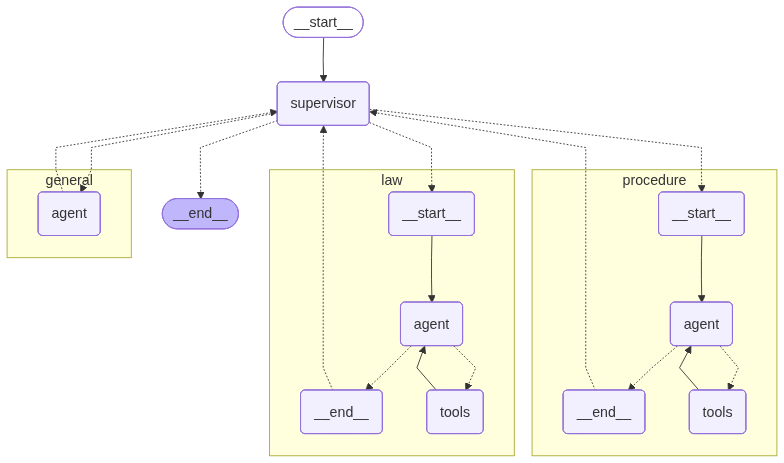

In [16]:
from IPython.display import display, Image
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [17]:
# from IPython.display import Image,Markdown
# def call_multi_agent_system(agent, prompt,userid,file_path=None):

#     config = {"configurable": {"thread_id": userid},
#             "recursion_limit": 20}
#     human_message_shown = False
#     events = agent.stream(
#         {"messages": [("user", prompt)],
#         "file_path": file_path,},
#         config = config,
#         stream_mode="messages",
#     )

#     for event in events:
#         # event is a tuple: (namespace, message)
#         namespace, message = event
        
#         # Check if message is HumanMessage
#         if isinstance(message, HumanMessage) and not human_message_shown:
#             display(Markdown(f"**Human:** {message.content}"))
#             human_message_shown = True

#         # Check if message is SystemMessage
#         elif isinstance(message, SystemMessage):
#             content = message.content
#             # Check if content contains a PDF file reference
#             if ".pdf" in content:
#                 display(Markdown(f"**Lexi:** I've prepared a fillable PDF form for you. Check your folder."))
#             else:
#                 display(Markdown(f"**Lexi:** {content}"))
                
#         # Handle AIMessage for streaming
#         elif isinstance(message, AIMessage):
#             if message.content:
#                 display(Markdown(f"**Lexi:** {message.content}"))


In [18]:
import asyncio
from IPython.display import clear_output, Markdown, display
async def call_multi_agent_system_async(agent, prompt, userid, file_path=None):
    config = {"configurable": {"thread_id": userid}, "recursion_limit": 20}
    
    display(Markdown(f"**Human:** {prompt}"))
    print("\n**Lexi:** ", end='', flush=True)
    
    accumulated_text = ""
    
    async for event in agent.astream_events(
        {"messages": [("user", prompt)], "file_path": file_path},
        config=config,
        version="v2"
    ):
        kind = event["event"]
        
        # Stream LLM tokens
        if kind == "on_chat_model_stream":
            content = event["data"]["chunk"].content
            if content:
                print(content, end='', flush=True)
                accumulated_text += content
    
    print("\n")

def call_multi_agent_system(agent, prompt, userid, file_path=None):
    # Run the async function in Jupyter's event loop
    import nest_asyncio
    nest_asyncio.apply()
    
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(
        call_multi_agent_system_async(agent, prompt, userid, file_path)
    )

In [20]:

call_multi_agent_system(app,"Who are you?","user_123",)

**Human:** Who are you?


**Lexi:** generalSupervisor decision: general
invoke general agent
Hi! I'm Lexi, your friendly legal assistant. I help explain Victorian laws and court procedures in simple terms. How can I assist you today?



In [21]:
call_multi_agent_system(app,"Under what section I have been charged and please explain me all the sections in detail","user_123","Image.jpg")

**Human:** Under what section I have been charged and please explain me all the sections in detail


**Lexi:** Using cached extraction
lawSupervisor decision: law
invoke law agent
Query for hashing: Road Safety Act 1986 section 49
Cache miss - retrieving from laws database


C:\Users\DELL\AppData\Local\Temp\ipykernel_16756\4090688032.py:18: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs: List[Document] = laws_retriever.get_relevant_documents(query)


NONONONONONONOcaching new result
Based on the information extracted from your charge sheet, you have been charged under the **Road Safety Act 1986**, specifically **Section 49(1)(b)**, which pertains to driving a motor vehicle with a blood alcohol concentration (BAC) exceeding the prescribed limit.

### Summary of Relevant Legislation
- **Section 49(1)(b) of the Road Safety Act 1986** states that a person must not drive a motor vehicle while there is present in their breath (or blood) more than the prescribed concentration of alcohol. In your case, the alleged reading was 0.166 grams per 210 litres of exhaled air, which is significantly over the legal limit (0.05 grams per 210 litres of exhaled air for fully licensed drivers).

### Statutory Interpretation Method Used
- **Literal Rule**: The direct wording of the statute is interpreted. Here, the section’s language describes a clear prohibition against driving with a BAC exceeding the legal limit.
  
#### Justification:
The phrasing of

In [121]:
call_multi_agent_system(app,"Why I have been charged for and what will happen next","user_123","sample_summons_melbourne_magistrates_court.pdf")

Human: Why I have been charged for and what will happen next

Using cached extraction
Supervisor decision: law
invoke law agent
Query for hashing: Road Safety Act 1986 (Vic) section 65 exceeding speed limits
Cache miss - retrieving from laws database
caching new result


Lexi: ### Summary of Relevant Legislation
- **Charge**: The charge against you is for exceeding the speed limit, specifically for driving a motor vehicle at 80 km/h in a zone where the posted speed limit is 60 km/h. This is covered under section 65 of the **Road Safety Act 1986 (Vic)**.
  
  **Plain English Interpretation**: You are being accused of driving faster than the law allows in a designated area. The law sets speed limits to ensure safety on the roads, and exceeding these limits can result in penalties.

### Statutory Interpretation Method Used
- **Method**: The **literal rule** of statutory interpretation has been applied here. This method focuses on the ordinary meaning of the text as it stands. The wording of section 65 of the Road Safety Act is straightforward in conveying that driving over the stipulated speed limit qualifies as an offence. 

### Citation of Legal Sources
- **Road Safety Act 1986 (Vic)**, section 65: This section stipulates the regulations concerning speeding and its legal consequences.

### Final Conclusion or Recommendation
- **Next Steps**: You are required to attend the scheduled hearing. Not attending could lead to a warrant for your arrest or the case being decided without your presence, potentially resulting in a default conviction. At the hearing, you can choose to plead guilty or not guilty.

- **Contact Information**: Should you have any questions regarding the charge or procedures, contact the court registry at the provided sample phone number.

It is advisable to seek legal counsel to discuss the implications of your plea and prepare for the hearing adequately, especially if you contest the charge.

In [159]:
call_multi_agent_system(app,"generate a form for Supreme court NOTICE OF OPPOSITION TO APPLICATION OTHER THAN FOR LEAVE TO APPEAL","user_123")

Human: generate a form for Supreme court NOTICE OF OPPOSITION TO APPLICATION OTHER THAN FOR LEAVE TO APPEAL

Supervisor decision: procedure
Invoke procedure


Lexi: I've prepared a fillable PDF form for you.                     [Download Supreme Court Summons Form](supreme_court_summons.pdf)

In [53]:
call_multi_agent_system(app,"What is the purpose of the Building and Construction Industry Security of Payment Act 2002?","user_123")

Human: What is the purpose of the Building and Construction Industry Security of Payment Act 2002?

Supervisor decision: law
invoke law agent


Lexi: ### Question Restatement:
What is the purpose of the Building and Construction Industry Security of Payment Act 2002?

### Relevant Legislation:
**Building and Construction Industry Security of Payment Act 2002 (Victoria)**

### Summary of the Legislation:
The Building and Construction Industry Security of Payment Act 2002 establishes a framework for the timely and efficient payment for construction work and related goods and services within the building and construction industry in Victoria. It outlines the rights of contractors and subcontractors to receive progress payments and provides mechanisms for resolving payment disputes.

### Plain English Interpretation:
The Act aims to ensure that people working in the building and construction industry are paid promptly for their work. It gives workers the right to request payments for work completed, and it sets out clear rules on how disputes over these payments should be handled. This is particularly important because delays in payment can create financial strain for those in this sector, from large contractors down to small subcontractors.

### Statutory Interpretation Method:
**Purposive Approach:** This approach is used to interpret the Act by looking at the overall purpose and intent behind it. The Act's primary aim is to improve cash flow in the construction industry and protect workers from payment disputes.

### Citation of Legal Sources:
- Building and Construction Industry Security of Payment Act 2002, No. 15 of 2002
- Relevant regulations include amendments or provisions from the Building and Construction Industry Security of Payment Regulations 2023.

### Conclusion/Recommendation:
The Building and Construction Industry Security of Payment Act 2002 is designed to protect the rights of those in the construction industry by facilitating timely payments and providing a clear framework for resolving payment disputes. If you are involved in a construction project, whether as a contractor, subcontractor, or supplier, it's important to familiarize yourself with this Act to safeguard your rights and ensure compliance.

In [184]:
call_multi_agent_system(app,"what did we talk about in our recent chats","user_123")

Human: what did we talk about in our recent chats

Supervisor decision: general
invoke general agent


Lexi: In our recent chats, we discussed your inquiries related to Victorian law. You asked about the purpose of the Building and Construction Industry Security of Payment Act 2002, and I provided a summary of its purpose. You also inquired about how to write an application to have a dismissal of an application for leave set aside, for which I provided a general outline and instructions. If there's anything specific you would like to revisit or any new questions, just let me know!